Nesse projeto uso LSTM para descobrir qual é o preço de fechamento do bitcoin. Uso 5 features relativas ao candle de negociação diária e prevejo o preço de fechamento do dia seguinte



In [ ]:
# !pip install keras-tuner
# !pip install tensorflow
# !pip install numpy
# !pip install pandas

In [ ]:
#Importar as bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import math
import datetime
import time

# Importar sklearn para avaliar o modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
# from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# Importar tensorflow para construir o modelo
import tensorflow as tf
import keras
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Importar bibliotecas para plotar gráficos

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



## Variaveis Globais

In [ ]:
TIME_STEP = 30              #número de dias usados para prever o futuro
JUMP_STEP = 1
NUM_FEATURES = 5
NUM_PREDICT_FUTURE = 1      #número do dia a serem preditos no futuro (prever o próximo dia? Prever o 7º dia?)


## Definição das Seeds


In [ ]:
import tensorflow as tf
import numpy as np

# Defina a semente do TensorFlow
tf.random.set_seed(190011106)

# Defina a semente do NumPy
np.random.seed(190011106)


## Importar a Base de Dados

In [ ]:
ticker = 'BTC-USD'
#1410825600
initial_period = int(time.mktime(datetime.datetime(2014, 9, 16, 0, 0).timetuple()))

#1675814400
final_period = int(time.mktime(datetime.datetime(2023, 2, 8, 0, 0).timetuple()))
# 3067 valores. 2300 é 75%
interval = '1d' # 1d, 1wk, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={initial_period}&period2={final_period}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')


Função para escolher os dados utilizados de forma sequencial. A cada t valores


In [ ]:
# def selecionaValores(df, jump_step):
#   return df[0::jump_step]

# df = selecionaValores(df, JUMP_STEP)

Preparação dos Dados:

In [ ]:
# Retira a Data e coloca como Index
df.index = df.pop('Date')

data.dropna(inplace=True)
data.reset_index(inplace = True)


Definir os dataframes dos objetivos a serem alcançados pelo modelo. O Y. Baseados no TimeStep e numero do dia a ser predito


In [ ]:
# Definir os dataframes dos objetivos a serem alcançados pelo modelo. O Y. Baseados no TimeStep e numero do dia a ser predito

ignoreDays = TIME_STEP + NUM_PREDICT_FUTURE - 1
index = np.array(df.index)[ignoreDays:]

# Dataframe com o valor de fechamento
target_df_Close = pd.DataFrame(df['Close'], index, ['Close']).rename(columns={'Close':'YClose'})

# Dataframe com a variação nominal entre os dias
array_change = np.array(target_df_Close.YClose) - np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Change = pd.DataFrame(array_change, index, columns=['Close']).rename(columns={'Close':'YChange'})

# Dataframe com a variação percentual entre os dias
array_variation = np.array(target_df_Change.YChange) / np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Variation = pd.DataFrame(array_variation*100, index, ['Close']).rename(columns={'Close':'YVariation'})

In [ ]:
df.Close.size, target_df_Close.size, target_df_Change.size, target_df_Variation.size

(3067, 3037, 3037, 3037)

In [ ]:
#plt.plot(df.index, df['Close'])

## Divisão em Treino, Validação e Teste

In [ ]:
# Divisão entre 70% treino, 10% validação e 20% teste
size = len(target_df_Close)
train_size = int(size * 0.7)
validation_size = int(size * 0.1)
test_size = size - train_size - validation_size

x_train_data = df[: train_size + TIME_STEP - 1]
x_val_data = df[ train_size : (train_size + validation_size + TIME_STEP - 1)]
x_test_data = df[train_size + validation_size : -NUM_PREDICT_FUTURE]

y_train_data = target_df_Close[: train_size]
y_val_data = target_df_Close[train_size : (train_size + validation_size)]
y_test_data = target_df_Close[(train_size + validation_size) :]


In [ ]:
size, train_size, validation_size, test_size

(3037, 2125, 303, 609)

In [ ]:
x_train_data.shape, x_val_data.shape, x_test_data.shape, y_train_data.shape, y_val_data.shape, y_test_data.shape

((2154, 5), (332, 5), (638, 5), (2125, 1), (303, 1), (609, 1))

Transforma os Dados, para que as features do X sejam normalizadas de acordo com o conjunto de teste.
Usa o Log do preço de fechamento como Y


In [ ]:
#Transforma os dados para suavizar as variações em escala absoluta
# Transforma input data
scaler_train_input = MinMaxScaler(feature_range=(0, 1))
scaled_train_input = scaler_train_input.fit_transform(x_train_data)

scaled_val_input = scaler_train_input.transform(x_val_data)
scaled_test_input = scaler_train_input.transform(x_test_data)

# Transforma output data para o log do resultado
# scaled_train_output = np.array(y_train_data)
# scaled_val_output = np.array(y_val_data)
# scaled_test_output = np.array(y_test_data)
scaled_train_output = np.log10(np.array(y_train_data))
scaled_val_output = np.log10(np.array(y_val_data))
scaled_test_output = np.log10(np.array(y_test_data))

Cria o Conjunto de dados para ser usado no modelo LSTM, conjuntos de n dias para prever o dia seguinte
Após essa etapa, os conjuntos X de treino, validação e teste ficam com as quantidades corretas definidas anteriormente


In [ ]:
def createDataset(x, y, time_step=1):
  input = []
  output = []
  for i in range(len(y)):
    row = np.array([e for e in x[i : i + time_step]])
    input.append(row)
    output.append(y[i])
  return np.array(input), np.array(output)

x_train, y_train = createDataset(scaled_train_input, scaled_train_output, TIME_STEP)
x_val, y_val = createDataset(scaled_val_input, scaled_val_output, TIME_STEP)
x_test, y_test = createDataset(scaled_test_input, scaled_test_output, TIME_STEP)

print(df.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3067, 5)
(2125, 30, 5) (2125, 1)
(303, 30, 5) (303, 1)
(609, 30, 5) (609, 1)


In [ ]:
train_size, validation_size, test_size

(2125, 303, 609)

## Construção do Modelo LSTM

### Random Search com LSTM



Uso de Random Search para escolher em 100 opções, com duas tentativas cada, o melhor conjunto de hiperparâmetros.

Foram pesquisados:
 - Camadas de LSTM1: 1 2, 3 ou 4;
 - Células em cada camada LSTM: 16, 32, 64, 80, 76, 92 ou 128;
 - Dropout entre as camadas: entre 0,2 e 0,4
 - Taxa de aprendizado do otimizador Adam: entre 0,001 e 0,1

In [ ]:
import keras_tuner as kt
def build_lstm_model(hp):
  model = keras.Sequential()
  for _ in range(hp.Int('num_lstm_layers', min_value=1, max_value=4)):
      model.add(LSTM(units=hp.Int('num_lstm_units', min_value=16, max_value=128, step=16), return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
      model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4)))
  model.add(Dense(1))

  optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  return model

earlystopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory='./drive/MyDrive/TCC/lstm_regression2/',
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=25, validation_data=(x_val, y_val), callbacks=[earlystopping], batch_size=32, verbose=2)
tuner.results_summary()

#Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0];
best_model.save('./drive/MyDrive/TCC/lstm_regression2/best_model_tunner.hdf5');
best_model.build(x_train.shape);
best_model.summary();
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0];


Trial 100 Complete [00h 04m 03s]
val_loss: 0.1093660406768322

Best val_loss So Far: 0.016184943728148937
Total elapsed time: 04h 27m 36s
Results summary
Results in ./drive/MyDrive/TCC/lstm_regression2/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 084 summary
Hyperparameters:
num_lstm_layers: 1
num_lstm_units: 48
dropout_rate: 0.2047778725655428
learning_rate: 0.05486272562976355
Score: 0.016184943728148937

Trial 055 summary
Hyperparameters:
num_lstm_layers: 1
num_lstm_units: 48
dropout_rate: 0.3036382369226458
learning_rate: 0.044711760735721605
Score: 0.016764204017817974

Trial 024 summary
Hyperparameters:
num_lstm_layers: 1
num_lstm_units: 48
dropout_rate: 0.3370683516591675
learning_rate: 0.028149024750815634
Score: 0.018632004968822002

Trial 029 summary
Hyperparameters:
num_lstm_layers: 1
num_lstm_units: 32
dropout_rate: 0.2175417396617746
learning_rate: 0.06452326133676373
Score: 0.018849167972803116

Trial 094 summary
Hyperparameters:
n

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:

# No teste anterior:
# print("Rodei 300 cenários, mas tive problema de conexão e apenas foram testados 288. Com isso apenas peguei os melhores parâmetros e não o modelo")
# print("val_loss: 0.011150936596095562\n"+
#       "tempo total: 6h 28min 14s\n"+
#       "Cenários abordados: 288\n"+
#       "Melhor Cenário:\n"+
#       "  - Número de Camadas: 1\n"+
#       "  - Número de Células por Camada: 128\n"+
#       "  - Taxa de Dropout: 0.21235\n"+
#       "  - Taxa de Aprendizado: 0.018102\n"
#       )

## Mostra Treina o melhor modelo com EarlyStop

Carrega o melhor modelo e o treina com um máximo de 500 épocas, mas com EarlyStop com patience de 100 

In [ ]:
best_model = load_model('./drive/MyDrive/TCC/lstm_regression2/best_model_tunner.hdf5')
best_model.build(x_train.shape);
best_model.summary();

earlystopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

#Define um checkpoint para a melhor época
checkpoint_path = './drive/MyDrive/TCC/lstm_regression2/best_model_earlyStop.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint, earlystopping]
#Train the best model
history = best_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=2,
                              callbacks=callbacks)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 48)            10368     
                                                                 
 dropout (Dropout)           (None, 30, 48)            0         
                                                                 
 dense (Dense)               (None, 30, 1)             49        
                                                                 
Total params: 10417 (40.69 KB)
Trainable params: 10417 (40.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 - 8s - loss: 0.3284 - val_loss: 0.0404 - 8s/epoch - 113ms/step
Epoch 2/500
67/67 - 1s - loss: 0.0685 - val_loss: 0.0335 - 1s/epoch - 15ms/step
Epoch 3/500
67/67 - 1s - loss: 0.0447 - val_loss: 0.0502 - 709ms/epoch - 11ms/step
Epoch 4/500
67/67 - 1s - loss: 0.0299 - val_loss: 0.0690 - 713ms/epoch - 11ms/step
Epoch 5/500
67/67 - 1s - loss: 0.0228 - val_loss: 0.1193 - 692ms/epoch - 10ms/step
Epoch 6/500
67/67 - 1s - loss: 0.0182 - val_loss: 0.1075 - 655ms/epoch - 10ms/step
Epoch 7/500
67/67 - 1s - loss: 0.0169 - val_loss: 0.1087 - 696ms/epoch - 10ms/step
Epoch 8/500
67/67 - 1s - loss: 0.0156 - val_loss: 0.1602 - 722ms/epoch - 11ms/step
Epoch 9/500
67/67 - 1s - loss: 0.0139 - val_loss: 0.1010 - 697ms/epoch - 10ms/step
Epoch 10/500
67/67 - 1s - loss: 0.0140 - val_loss: 0.0982 - 756ms/epoch - 11ms/step
Epoch 11/500
67/67 - 1s - loss: 0.0131 - val_loss: 0.0962 - 717ms/epoch - 11ms/step
Epoch 12/500
67/67 - 1s - loss: 0.0126 - val_loss: 0.0852 - 715ms/epoch - 11ms/step
Epoch 13/500
67/67

## Resultados do Treino e da Validação

Mostra a loss, que é mean_squared_error



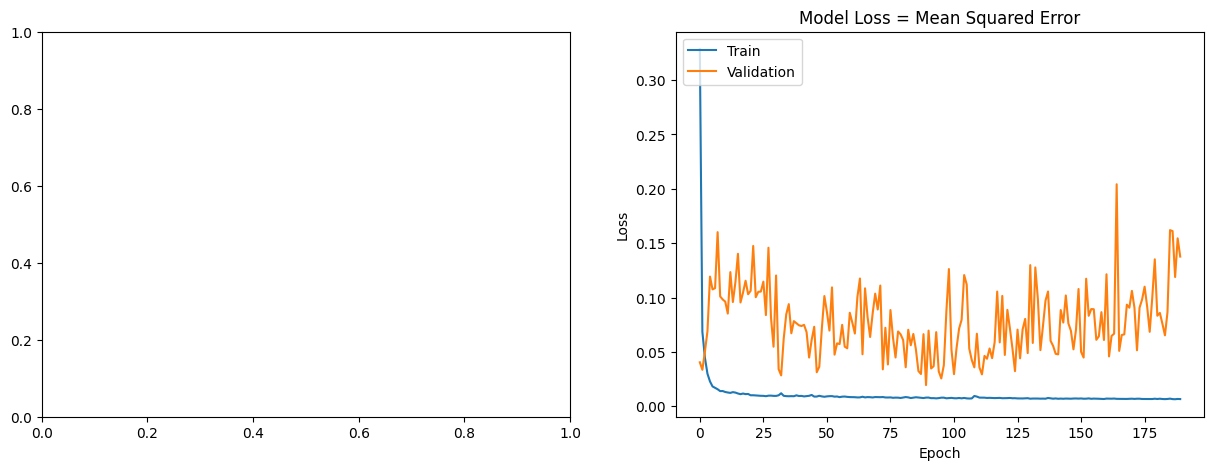

10/10 [==============================] - 0s 4ms/step
Mean Squared Error (MSE): 0.016113716357197976
Root Mean Squared Error (RMSE): 0.12693981391666673
Mean Absolute Error (MAE): 0.09495217779143617
Coefficient of Determination (R-squared): 0.7932416042694121


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(history.history['root_mean_squared_error'])
# ax1.plot(history.history['val_root_mean_squared_error'])
# ax1.set_title('Model root_mean_squared_error')
# ax1.set_ylabel('root_mean_squared_error')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss = Mean Squared Error')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

y_val_predict = best_model.predict(x_val)
y_val_predict_results = y_val_predict[:, -1, 0]

# Calcular e imprimir as métricas de regressão
mse = mean_squared_error(y_val, y_val_predict_results)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_predict_results)
r2 = r2_score(y_val, y_val_predict_results)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Coefficient of Determination (R-squared): {r2}")